In [155]:
import pandas as pd
from memo import memo
import jax
import jax.numpy as np
from enum import IntEnum, auto
# read in files
# Read UK_df.csv as pandas dataframe
original_UK_dialogue = pd.read_csv('UK_df.csv')
original_UK_politeness = pd.read_csv('UK_direct_df.csv')
original_UK_narrator = pd.read_csv('UK_narrator_df.csv')
original_US_dialogue = pd.read_csv('US_df.csv')
original_US_politeness = pd.read_csv('US_direct_df.csv')
original_US_narrator = pd.read_csv('US_narrator_df.csv')
dataframes = [original_UK_dialogue, original_UK_politeness, original_UK_narrator, original_US_dialogue, original_US_politeness, original_US_narrator]
def elim_outliers(df):
    # dropped Unnamed: 0 column
    df.drop(columns=['Unnamed: 0'], inplace=True)
    filtered_df = df.loc[(df['response'] > 95) | (df['response'] < 5)]
    for id in df['person_id'].unique():
        if len(filtered_df[filtered_df['person_id'] == id])/len(df[df['person_id'] == id])>0.8:
            df.drop(df[df['person_id'] == id].index, inplace=True)
    df['predicate Z-score'] = df.groupby(['person_id','predicate'])['response'].transform(lambda x: (x - x.mean()) / x.std())
    # if has_intensifier = no then change 'intensifier' to 'none'
    df.loc[df['has intensifier?'] == 'no', 'intensifier'] = 'none'
    return df
for i in range(len(dataframes)):
    dataframes[i] = elim_outliers(dataframes[i])
dialogue = pd.concat([dataframes[0], dataframes[3]])
politeness = pd.concat([dataframes[1], dataframes[4]])
UK_dialogue = dataframes[0]
US_dialogue = dataframes[3]
UK_politeness = dataframes[1]
US_politeness = dataframes[4]

# end of reading in data
#-------------------------------------------------------------------------------

# compute U_soc (social Utility)
U_soc_data = politeness.groupby(['intensifier','predicate'])['predicate Z-score'].mean().to_dict()
UK_U_soc_data = UK_politeness.groupby(['intensifier','predicate'])['predicate Z-score'].mean().to_dict()
US_U_soc_data = US_politeness.groupby(['intensifier','predicate'])['predicate Z-score'].mean().to_dict()

Define params to iterate

In [156]:
class W(IntEnum):  # utterance space
    # intensifiers
    none = auto(0)
    slightly= auto()
    kind_of = auto()
    quite = auto()
    very= auto()
    extremely= auto()
class P(IntEnum):
    # predicates
    boring = auto(0)
    concerned = auto()
    difficult = auto()
    exhausted = auto()
    helpful = auto()
    impressive = auto()
    understandable = auto()
    

In [157]:
# Create a list of JAX arrays
UK_measured_values = []
indexes = [0]
for p in P:
    for w in W:
        intensifier = w.name.replace('_'," ")
        predicate = p.name
        raw_values = UK_dialogue[((UK_dialogue['intensifier'] == intensifier) & (UK_dialogue['predicate'] == predicate))]['predicate Z-score'].values
        UK_measured_values.append(raw_values)
        indexes.append(len(raw_values) + indexes[-1])


Define constants

In [158]:
epsilon = 0.01
infty = 10000000
S = np.concat(UK_measured_values)  # Concatenate all the JAX arrays into one
relevant_values = np.zeros((len(W)*len(P),len(S)),dtype=int)
for i in range(len(W)*len(P)):
    relevant_values = relevant_values.at[i, indexes[i]:indexes[i+1]].set(1)
relevant_values = np.transpose(relevant_values)  # Transpose to match the shape of S

Construct measured_values which is an array of 42 arrays where the i'th entry is the values people reported for the i'th utterance

In [159]:
@jax.jit
def state_prior(s):
    return np.exp(-s**2/2) # we assume s is roughly a gaussian distribution

@jax.jit
def UK_U_soc(intensifier,predicate):
    arr = np.array([
        [UK_U_soc_data[(w.name.replace('_'," "),p.name)] for p in P] 
        for w in W
    ])
    return arr[intensifier,predicate]
@jax.jit
def is_costly(w):
    arr = [0, 1, 1, 1, 1, 1]
    return np.array(arr)[w]
@jax.jit
def L(w, s,t0,t1,t2,t3,t4,t5,w0,w1,w2,w3,w4,w5):  # literal likelihood L(w | s)
    t = np.array([t0,t1,t2,t3,t4,t5])[w]
    width = np.array([w0,w1,w2,w3,w4,w5])[w]
    sigt = 1 / (1 + np.exp(-t))
    width = np.maximum( width, 0)  # prevent division by zero
    sigt_high = 1 / (1 + np.exp(-t-width))
    low_threshold = sigt * 5.6 - 2.8
    high_threshold = sigt_high * 5.6 - 2.8
    return jax.lax.cond(
        (low_threshold< s) & (s < high_threshold),  # If condition (s is in the range)
        lambda: (5.6 - epsilon * (5.6+low_threshold-high_threshold)) / (high_threshold-low_threshold),  # s and threshold can range from -2.8 to 2.8
        lambda: epsilon  # If condition (t > s) is True
    )

@memo
def UKL1[s: S, w: W](inf_term, soc_term, cost,t0,t1,t2,t3,t4,t5,w0,w1,w2,w3,w4,w5,p):
    listener: thinks[
        speaker: given(s in S, wpp=state_prior(s)),
        speaker: chooses(w in W, wpp=
            imagine[
                listener: knows(w),
                listener: chooses(s in S, wpp=L(w, s,t0,t1,t2,t3,t4,t5,w0,w1,w2,w3,w4,w5)) ,
                exp(inf_term * log(Pr[listener.s == s]) + 
                soc_term * UK_U_soc(w,p) - # U_soc = listener's EU
                cost*is_costly(w)) # U_inf = listener's surprisal       
            ]
        )
    ]
    listener: observes[speaker.w] is w
    listener: chooses(s in S, wpp=Pr[speaker.s == s])
    return Pr[listener.s == s]

In [160]:
def UK_soc_logloss(*params):
    widths = params[:6]
    thetas = params[6:12]
    cost = params[12]
    inf_term = params[13]
    soc_term = params[14]
    P_l1 = np.concatenate([UKL1(inf_term=inf_term, soc_term=soc_term, cost=cost, t0 = thetas[0],t1=thetas[1], t2= thetas[2], t3 = thetas[3], t4 = thetas[4], t5 = thetas[5], w0 = widths[0],w1=widths[1], w2= widths[2], w3 = widths[3], w4 = widths[4], w5 = widths[5],p=p) for p in P],axis = 1)
    return np.sum(np.log(P_l1)*relevant_values)

In [ ]:
import matplotlib.pyplot as plt
import jax.random as jr
import optax
optimizer = optax.adam(learning_rate=0.001)
key = jr.PRNGKey(42)  # Random seed
keys = jr.split(key, 10)  # Generate 10 random keys
vg = jax.value_and_grad(UK_soc_logloss, argnums=range(15))
for m in range(10):
    losses = [] 
    squares = []
    betas = []
    bests= [-15000]
    # generate tuple of 9 random numbers between -3 and 3 and 6 random numbers between 0 and 3
    beta = tuple(jr.uniform(keys[m], shape=(9,), minval=-3, maxval=3))
    width = tuple(jr.uniform(keys[m], shape=(6,), minval=-1, maxval=0))
    beta =width+beta
    opt_state = optimizer.init(beta)
    params = []
    for i in range(1000):
        l, dbeta = vg(*beta)
        if bests[-1]<l:
            bests.append(l)
        else:
            bests.append(bests[-1])
        if i%100 == 0:
            print(l,i,beta)
        losses.append(l)
        betas.append(beta)
        updates,opt_state = optimizer.update(tuple(-i for i in dbeta), opt_state)
        beta = optax.apply_updates(beta, updates)  # Update weights
        beta = tuple(np.maximum(np.array(beta[:6]),0))+beta[6:]
        print(opt_state,'\n',beta)

    # Create the figure and first y-axis
    fig, ax1 = plt.subplots(figsize=(8, 5))
    ax1.plot(np.arange(len(losses)), losses,label ="losses", color='r')

    plt.ylim(np.max(np.array(losses))-100, np.max(np.array(losses)))
    # print([np.round(num.item() for num in tuple(jr.uniform(keys[m], shape=(9,), minval=-3, maxval=3))])
    plt.title('Loglosses')
    plt.show()
    # Create 9 subplots in a 3x3 grid
    fig, axes = plt.subplots(nrows=5, ncols=3,figsize = (20,20))
    # Example: Plot random data in each subplot
    for i in range(5):
        for j in range(3):
            if i<2:
                axes[i,j].plot(np.arange(len(losses)), [1 / (1 + np.exp(-betas[k][3*i+j]-betas[k][3*i+j+6])) for k in range(len(betas))],label ="losses", color='r')
            elif i<4:
                axes[i,j].plot(np.arange(len(losses)), [1 / (1 + np.exp(-betas[k][3*i+j])) for k in range(len(betas))],label ="losses", color='r')
            else:
                axes[i,j].plot(np.arange(len(losses)), [betas[k][3*i+j] for k in range(len(betas))],label ="losses", color='r')
    plt.show()

(Array(-0.4697392, dtype=float32), Array(-0.6866379, dtype=float32), Array(-0.09846973, dtype=float32), Array(-0.3016671, dtype=float32), Array(-0.3819344, dtype=float32), Array(-0.37814796, dtype=float32), Array(0.18156481, dtype=float32), Array(-1.1198273, dtype=float32), Array(2.4091816, dtype=float32), Array(1.1899974, dtype=float32), Array(0.7083936, dtype=float32), Array(0.73111224, dtype=float32), Array(1.3064804, dtype=float32), Array(-1.7417994, dtype=float32), Array(-2.8596718, dtype=float32))
-11114.84 0 (Array(-0.4697392, dtype=float32), Array(-0.6866379, dtype=float32), Array(-0.09846973, dtype=float32), Array(-0.3016671, dtype=float32), Array(-0.3819344, dtype=float32), Array(-0.37814796, dtype=float32), Array(0.18156481, dtype=float32), Array(-1.1198273, dtype=float32), Array(2.4091816, dtype=float32), Array(1.1899974, dtype=float32), Array(0.7083936, dtype=float32), Array(0.73111224, dtype=float32), Array(1.3064804, dtype=float32), Array(-1.7417994, dtype=float32), Arra

KeyboardInterrupt: 

### Below this, I used np.maximum and np.minimum to clip rather than sigmoid functions

In [ ]:
import matplotlib.pyplot as plt
import jax.random as jr
import optax
optimizer = optax.adam(learning_rate=0.001)
key = jr.PRNGKey(42)  # Random seed
keys = jr.split(key, 10)  # Generate 10 random keys
vg = jax.value_and_grad(normal_UK_soc_logloss, argnums=range(15))
for m in range(1,10):
    losses = [] 
    squares = []
    betas = []
    bests= [-15000]
    # generate tuple of 9 random numbers between -3 and 3 and 6 random numbers between 0 and 3
    beta = tuple(jr.uniform(keys[m], shape=(9,), minval=-3, maxval=3))
    width = tuple(jr.uniform(keys[m], shape=(6,), minval=0, maxval=3))
    beta =width+beta
    print(beta)
    opt_state = optimizer.init(beta)
    params = []
    for i in range(4000):
        l, dbeta = vg(*beta)
        if bests[-1]<l:
            bests.append(l)
        else:
            bests.append(bests[-1])
        if i%100 == 0:
            print(l,i,beta)
        losses.append(l)
        betas.append(beta)
        updates,opt_state = optimizer.update(tuple(-i for i in dbeta), opt_state)
        beta = optax.apply_updates(beta, updates)  # Update weights
        beta = beta[:6]+tuple(np.minimum(np.maximum(np.array(beta[6:12]),-2.8),2.8))+beta[12:]
        beta = tuple(np.minimum(np.maximum(np.array(beta[:6]),0),2.8-np.array(beta[6:12])))+beta[6:]

(Array(2.1829927, dtype=float32), Array(2.3636026, dtype=float32), Array(0.5450828, dtype=float32), Array(0.7878907, dtype=float32), Array(0.332188, dtype=float32), Array(0.6078923, dtype=float32), Array(1.3659854, dtype=float32), Array(1.7272053, dtype=float32), Array(-1.9098344, dtype=float32), Array(-1.4242187, dtype=float32), Array(-2.335624, dtype=float32), Array(-1.7842155, dtype=float32), Array(-1.0938692, dtype=float32), Array(-2.366578, dtype=float32), Array(-0.42096233, dtype=float32))
-11359.814 0 (Array(2.1829927, dtype=float32), Array(2.3636026, dtype=float32), Array(0.5450828, dtype=float32), Array(0.7878907, dtype=float32), Array(0.332188, dtype=float32), Array(0.6078923, dtype=float32), Array(1.3659854, dtype=float32), Array(1.7272053, dtype=float32), Array(-1.9098344, dtype=float32), Array(-1.4242187, dtype=float32), Array(-2.335624, dtype=float32), Array(-1.7842155, dtype=float32), Array(-1.0938692, dtype=float32), Array(-2.366578, dtype=float32), Array(-0.42096233, d

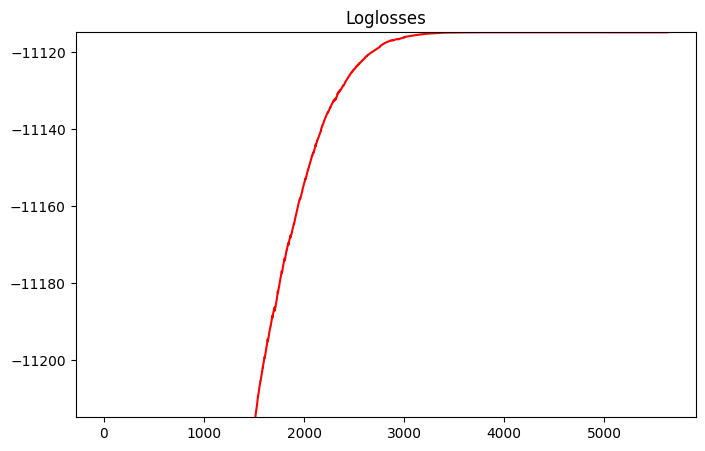

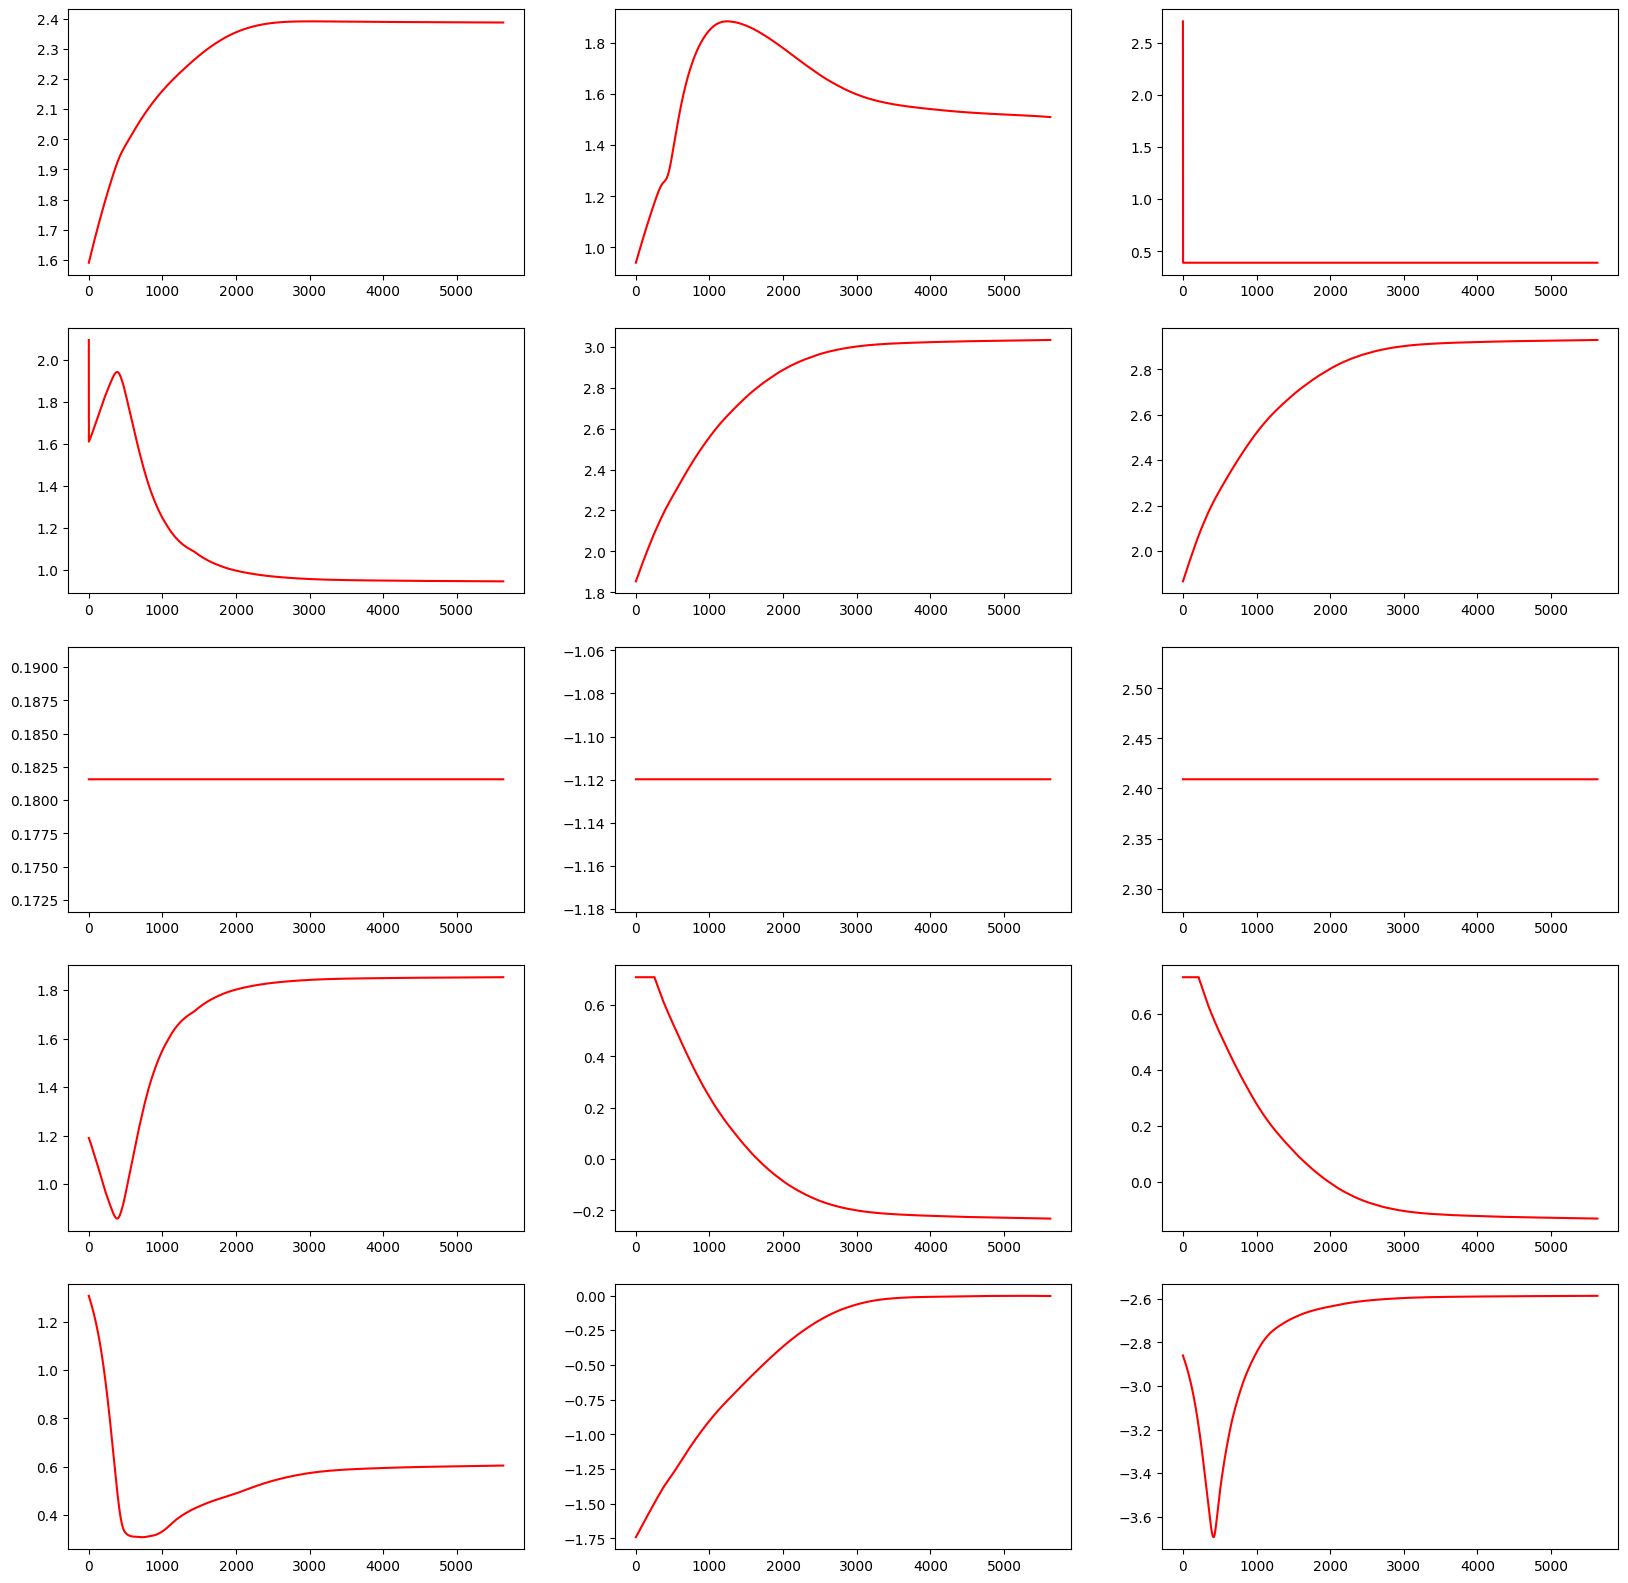

In [175]:

# Create the figure and first y-axis
fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.plot(np.arange(len(losses)), losses,label ="losses", color='r')

plt.ylim(np.max(np.array(losses))-100, np.max(np.array(losses)))
# print([np.round(num.item() for num in tuple(jr.uniform(keys[m], shape=(9,), minval=-3, maxval=3))])
plt.title('Loglosses')
plt.show()
# Create 9 subplots in a 3x3 grid
fig, axes = plt.subplots(nrows=5, ncols=3,figsize = (20,20))
# Example: Plot random data in each subplot
for i in range(5):
    for j in range(3):
        axes[i,j].plot(np.arange(len(losses)), [betas[k][3*i+j] for k in range(len(betas))],label ="losses", color='r')
plt.show()

### Trying different sigmas (variences) and plotting different distributions of parameters

In [105]:
import cma
best_params_arr = []
best_values_arr = []
def wrapped_loss(x):
    result = UK_soc_logloss(*tuple(x))  # Unpack the parameters from the tuple
    return -result.item()

for sigma in [0.01,0.1, 0.5,1,3]:
    best_params_list = []
    best_values_list = []
    for _ in range(5):
        # Get best solution
        es = cma.CMAEvolutionStrategy(
            [0.3] * 15,    # initial guess
            sigma, # sigma
            {"bounds": [[0]*6+[None]*9, None],'tolfunhist': 1e-16,'tolflatfitness': 10,'tolfun': 1e-12},
        )
        es.optimize(wrapped_loss)
        best_params = es.result.xbest
        best_value = -es.result.fbest  # Negate to get the original loss value
        print(es.stop())
        print("Best value found:", best_value)
        print("Best parameters found:", best_params)
        best_params_list.append(best_params)
        best_values_list.append(best_value)
    best_params_arr.append(best_params_list)
    best_values_arr.append(best_values_list)



(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 15 (seed=709214, Wed Apr  2 10:34:00 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 1.111487304687500e+04 1.0e+00 8.99e-03  9e-03  9e-03 0:00.0
    2     24 1.111359667968750e+04 1.1e+00 8.39e-03  8e-03  9e-03 0:00.1
    3     36 1.111562402343750e+04 1.2e+00 8.03e-03  8e-03  8e-03 0:00.1
   94   1128 1.110039453125000e+04 4.0e+00 7.54e-04  4e-04  8e-04 0:03.1
  100   1200 1.110048828125000e+04 4.0e+00 5.64e-04  3e-04  6e-04 0:03.3
  200   2400 1.109915625000000e+04 1.2e+01 3.12e-04  9e-05  7e-04 0:06.2
  300   3600 1.109776757812500e+04 4.8e+01 6.01e-04  1e-04  4e-03 0:09.0
  400   4800 1.109722460937500e+04 7.8e+01 5.52e-04  9e-05  4e-03 0:11.6
  500   6000 1.109679882812500e+04 3.1e+02 3.19e-04  3e-05  5e-03 0:14.1
  600   7200 1.109676269531250e+04 6.0e+02 7.99e-05  5e-06  1e-03 0:16.7
  700   8400 1.109675585937500e+04 6.1e+02 3.26e-05  2e-06  4e-04 0:19.5
  800   9600 1.109674804687500e+0

   65    780 1.111483984375000e+04 3.0e+00 2.01e+00  1e+00  3e+00 0:01.7
{'tolflatfitness': 10}
Best value found: -11076.904296875
Best parameters found: [ 1.70562006  1.84947882  7.79557344  0.93868246  0.17168735  1.69143031
 -9.06173375  7.38412121  9.1322102   2.62837536  3.84119332  1.26122433
 -8.97630759  0.30829819  1.70755718]
(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 15 (seed=664384, Wed Apr  2 10:45:33 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 1.112855859375000e+04 1.0e+00 2.74e+00  3e+00  3e+00 0:00.0
    2     24 1.111765332031250e+04 1.1e+00 2.57e+00  2e+00  3e+00 0:00.1
    3     36 1.123164941406250e+04 1.2e+00 2.48e+00  2e+00  3e+00 0:00.1


  100   1200 1.110831152343750e+04 5.2e+00 7.89e-01  3e-01  1e+00 0:02.7
  200   2400 1.108897070312500e+04 2.1e+01 3.78e-01  3e-02  5e-01 0:05.4
  300   3600 1.108824316406250e+04 8.2e+01 7.54e-02  2e-03  1e-01 0:08.1
  400   4800 1.108824218750000e+04 1.3e+02 1.98e-02  5e-04  3e-02 0:10.8
  500   6000 1.108824218750000e+04 1.9e+02 1.62e-02  4e-04  2e-02 0:13.5
  600   7200 1.108824218750000e+04 3.2e+02 1.01e-02  2e-04  1e-02 0:16.2
  700   8400 1.108824218750000e+04 6.2e+02 2.86e-03  8e-05  4e-03 0:18.9
  711   8532 1.108824218750000e+04 6.5e+02 2.37e-03  6e-05  4e-03 0:19.2
{'tolfunhist': 1e-16}
Best value found: -11076.62890625
Best parameters found: [ 2.98810351  3.67157732  2.83260675  2.2229683   1.77751398  4.74086654
  0.74555545  4.88522048 -5.59994252  5.17654893  3.41744748  4.72762424
  2.00384204 -0.32992114 -0.56568913]
(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 15 (seed=636147, Wed Apr  2 10:45:54 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max s

  100   1200 1.094574414062500e+04 8.4e+00 8.35e-01  2e-01  1e+00 0:02.8
  200   2400 1.093659179687500e+04 3.0e+01 1.33e-01  1e-02  2e-01 0:05.5
  300   3600 1.093489843750000e+04 2.3e+02 3.96e-02  1e-03  7e-02 0:08.2
  400   4800 1.093488476562500e+04 2.0e+03 6.00e-02  6e-04  2e-01 0:10.8
  445   5340 1.093488476562500e+04 2.8e+03 5.20e-02  4e-04  2e-01 0:12.1
{'tolfunhist': 1e-16}
Best value found: -10934.884765625
Best parameters found: [  1.82852982   8.28720877   1.72962047   5.68186117   2.31903664
   4.66012866   3.08864062  -9.11159257   5.8404186  -11.42693342
  -9.95034894  22.31273263  16.32134367   0.57784094   8.96810418]


[-11053.740234375, -10914.1298828125, -10700.443359375, -11064.923828125, -11097.095703125]


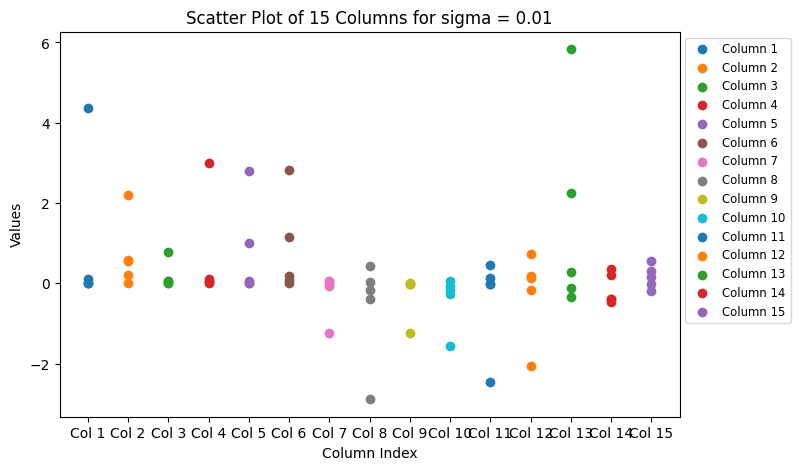

[-10759.5439453125, -10760.3193359375, -10709.232421875, -10994.84765625, -10756.193359375]


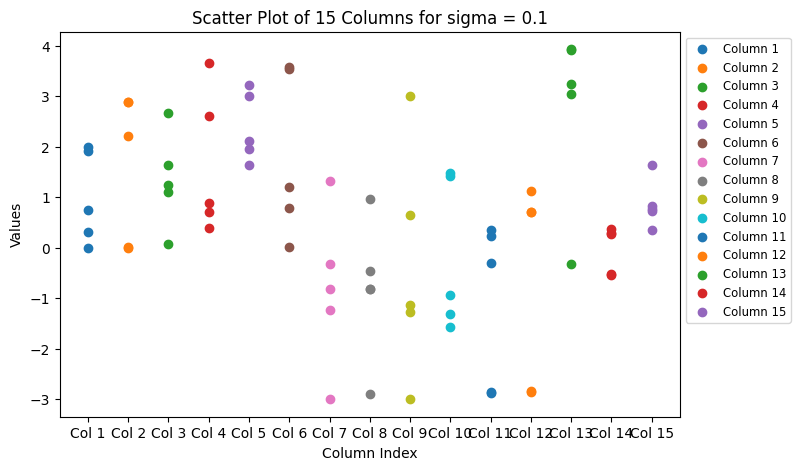

[-10771.720703125, -10764.0703125, -10740.3544921875, -10970.708984375, -10734.61328125]


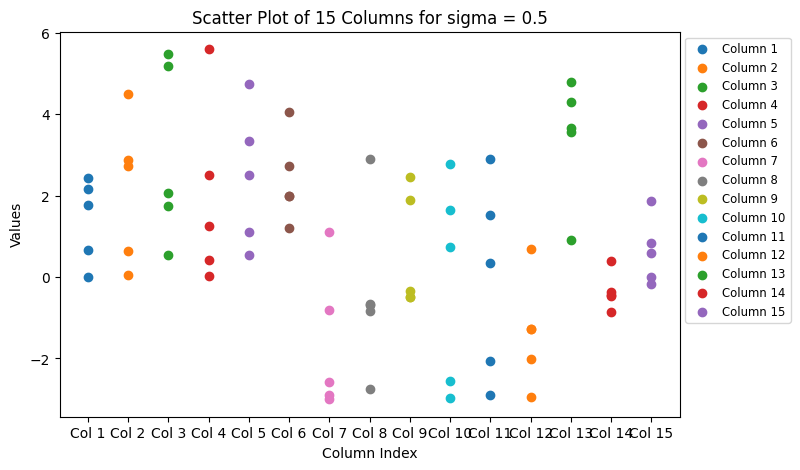

[-10842.384765625, -10805.666015625, -10869.19140625, -10906.6015625, -10900.728515625]


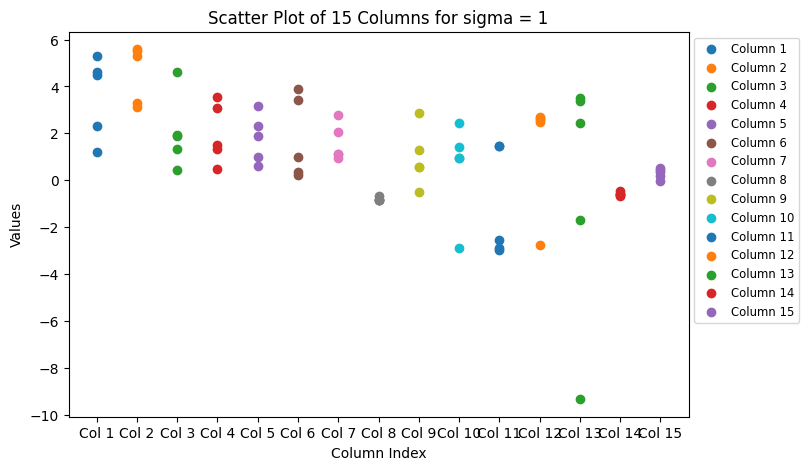

[-10908.4970703125, -10774.12890625, -10813.0947265625, -10815.5634765625, -10930.78125]


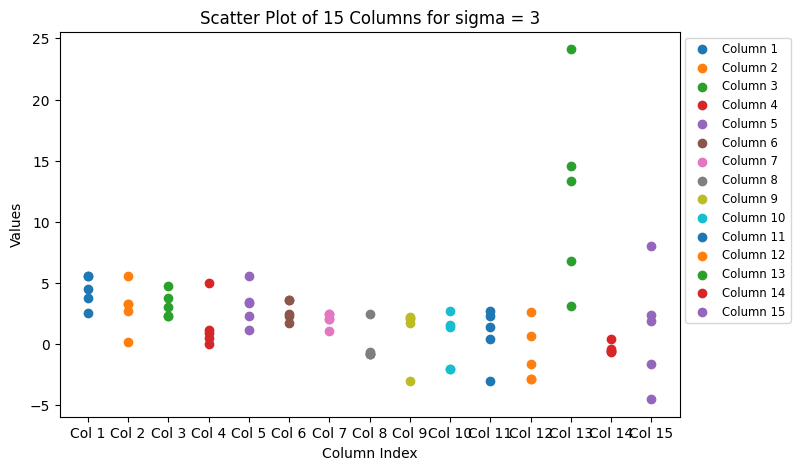

In [121]:
import matplotlib.pyplot as plt

# Define x-axis positions for each column
x_positions = np.arange(15)  # 6 columns
arr = [0.01,0.1,0.5,1,3]
# Create scatter plot
for graph in range(5):
    plt.figure(figsize=(8, 5))
    print(best_values_arr[graph])
    for i in range(15):  # Iterate over each column
        y_values = np.array(best_params_arr[graph])[:, i]  # Extract 10 points from each column
        x_values = np.full(5, x_positions[i])  # Align x-values for scatter
        plt.scatter(x_values, y_values, label=f"Column {i+1}")

    # Labeling
    plt.xlabel("Column Index")
    plt.ylabel("Values")
    plt.title(f"Scatter Plot of 15 Columns for sigma = {arr[graph]}")
    plt.xticks(x_positions, [f"Col {i+1}" for i in range(15)])  # Custom x-ticks

    # plot legend on outside
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
    plt.show()


### trying similar CMA-ES algorithm but where we use raw threshold values and define bounds
- adjusted scaling for params of inf, soc so that varience of possible parameters is 1, around the same as threshold variance

In [ ]:
def normal_wrapped_loss(x):
    result = normal_UK_soc_logloss(*tuple(x))  # Unpack the parameters from the tuple
    return -result.item()

@jax.jit
def normal_L(w, s,t0,t1,t2,t3,t4,t5,w0,w1,w2,w3,w4,w5):  # literal likelihood L(w | s)
    t = np.array([t0,t1,t2,t3,t4,t5])[w]
    width = np.array([w0,w1,w2,w3,w4,w5])[w]
    low_threshold = t
    high_threshold = np.minimum(t+width,2.8)  # Ensure high_threshold does not exceed 2.8
    return jax.lax.cond(
        (low_threshold< s) & (s < high_threshold),  # If condition (s is in the range)
        lambda: (5.6 - epsilon * (5.6+low_threshold-high_threshold)) / (high_threshold-low_threshold),  # s and threshold can range from -2.8 to 2.8
        lambda: epsilon  # If condition (t > s) is True
    )

@memo
def normal_UKL1[s: S, w: W](inf_term, soc_term, cost,t0,t1,t2,t3,t4,t5,w0,w1,w2,w3,w4,w5,p):
    listener: thinks[
        speaker: given(s in S, wpp=state_prior(s)),
        speaker: chooses(w in W, wpp=
            imagine[
                listener: knows(w),
                listener: chooses(s in S, wpp=normal_L(w, s,t0,t1,t2,t3,t4,t5,w0,w1,w2,w3,w4,w5)) ,
                exp(0.3*inf_term * log(Pr[listener.s == s]) + 
                0.5*soc_term * UK_U_soc(w,p) - # U_soc = listener's EU
                10*cost*is_costly(w)) # U_inf = listener's surprisal       
            ]
        )
    ]
    listener: observes[speaker.w] is w
    listener: chooses(s in S, wpp=Pr[speaker.s == s])
    return Pr[listener.s == s]

def normal_UK_soc_logloss(*params):
    widths = params[:6]
    thetas = params[6:12]
    cost = params[12]
    inf_term = params[13]
    soc_term = params[14]
    P_l1 = np.concatenate([normal_UKL1(inf_term=inf_term, soc_term=soc_term, cost=cost, t0 = thetas[0],t1=thetas[1], t2= thetas[2], t3 = thetas[3], t4 = thetas[4], t5 = thetas[5], w0 = widths[0],w1=widths[1], w2= widths[2], w3 = widths[3], w4 = widths[4], w5 = widths[5],p=p) for p in P],axis = 1)
    return np.sum(np.log(P_l1)*relevant_values)
best_params_list = []
best_values_list = []
for _ in range(5):
    # Get best solution
    es = cma.CMAEvolutionStrategy(
        [0.0] * 15,    # initial guess
        1, # sigma
        {"bounds": [[0]*6+[-3]*6+[None]*3, [5.6]*6+[3]*6+[None]*3],'tolfunhist': 1e-14,'tolflatfitness': 10,'tolfun': 1e-10},
    )
    es.optimize(normal_wrapped_loss)
    best_params = es.result.xbest
    best_value = -es.result.fbest  # Negate to get the original loss value
    print(es.stop())
    print("Best value found:", best_value)
    print("Best parameters found:", best_params)
    best_params_list.append(best_params)
    best_values_list.append(best_value)

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 15 (seed=794086, Wed Apr  2 13:46:52 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 1.111304882812500e+04 1.0e+00 9.17e-01  9e-01  9e-01 0:00.4
    2     24 1.110977929687500e+04 1.1e+00 8.63e-01  8e-01  9e-01 0:00.4
    3     36 1.109629980468750e+04 1.2e+00 8.37e-01  8e-01  9e-01 0:00.4
   79    948 1.075760546875000e+04 4.0e+00 1.39e-01  6e-02  2e-01 0:03.5
  100   1200 1.074986718750000e+04 4.3e+00 7.03e-02  3e-02  8e-02 0:04.3
  200   2400 1.074031054687500e+04 9.1e+00 4.65e-03  1e-03  5e-03 0:08.0
  300   3600 1.073923046875000e+04 2.7e+01 2.40e-03  2e-04  3e-03 0:13.4
  400   4800 1.073884765625000e+04 3.6e+01 1.25e-03  8e-05  1e-03 0:17.0
  500   6000 1.073864843750000e+04 1.6e+02 3.56e-03  2e-04  1e-02 0:20.4
  600   7200 1.073836523437500e+04 1.7e+02 2.90e-03  1e-04  8e-03 0:23.8
  700   8400 1.073835351562500e+04 9.4e+01 3.50e-04  1e-05  4e-04 0:27.4
  800   9600 1.073835156250000e+0

[-10738.3515625, -10701.787109375, -10787.97265625, -10831.65625, -10795.4912109375]


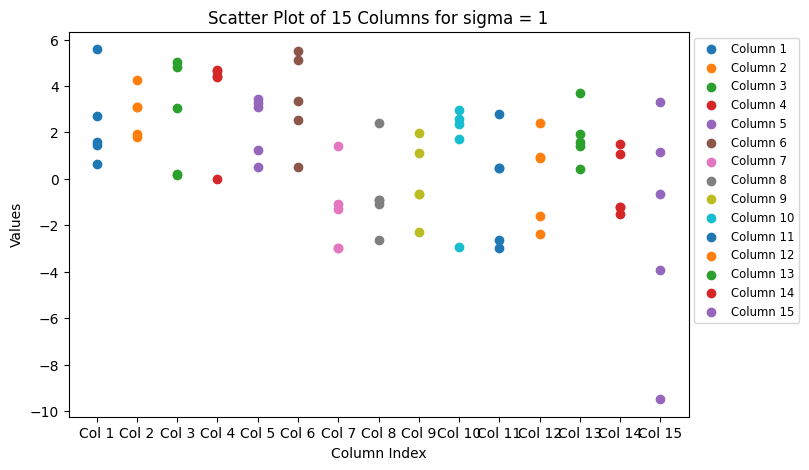

[array([ 1.47120294,  3.07730366,  0.18472822,  4.42287509,  3.11215281,
         3.33716693, -2.9999498 , -0.91037381,  1.09935297,  2.94913394,
        -2.64141747, -2.39769946,  1.43118164, -1.22634505, -3.94172277]),
 array([ 2.71513151,  1.7982969 ,  3.03843924,  4.66950546,  1.25539053,
         5.13059696, -1.3130178 , -2.63890261, -2.29629316, -2.95665369,
         0.47352913,  0.87721217,  1.56881817,  1.07473438, -0.64033953]),
 array([ 5.58147583,  1.93506484,  0.21158517,  4.62642847,  3.24455793,
         5.5240357 , -1.084964  ,  2.3871181 ,  1.95499378,  2.59187396,
         0.47371396,  0.93946837,  0.43567985,  1.48044913,  1.13906423]),
 array([ 1.59707867e+00,  3.07680467e+00,  5.04650495e+00,  6.20455527e-03,
         3.43762919e+00,  4.93900388e-01,  1.40190724e+00, -9.10050515e-01,
        -6.63404511e-01,  2.35415679e+00, -2.96388861e+00,  2.42404040e+00,
         3.68641526e+00, -1.19592654e+00, -9.49288309e+00]),
 array([ 0.62456663,  4.24448515,  4.80258648,  

In [154]:
plt.figure(figsize=(8, 5))
print(best_values_list)
for i in range(15):  # Iterate over each column
    y_values = np.array(best_params_list[-5:])[:, i]  # Extract 10 points from each column
    x_values = np.full(5, x_positions[i])  # Align x-values for scatter
    plt.scatter(x_values, y_values, label=f"Column {i+1}")

# Labeling
plt.xlabel("Column Index")
plt.ylabel("Values")
plt.title(f"Scatter Plot of 15 Columns for sigma = {1}")
plt.xticks(x_positions, [f"Col {i+1}" for i in range(15)])  # Custom x-ticks

# plot legend on outside
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
plt.show()
best_params_list

In [ ]:
# BIC equation: -2*log(L) + k*log(n) where n is sample size, log(L) is the loglossand k is the number of parameters the model estimates

# AIC = -2 * log(L) + 2 * k 

# n is 1496 (number of data points) so each additional parameter is worth about 1.5 logloss points